# Forecasting android app company privacy permissions requests
Michael Steckler, Chelsea Shu, Julian Pelzner, and Ollie Downs 
## Introduction
With the rise of new regulations, such as GDPR, privacy compliance organizations will need to forecast their future workflows. In order to complete and review permissions requests for mobile applications worldwide, privacy compliance organizations will need to hire compliance analysts, which affects their labor expenditures. We want to help these organizations with these forecasting tasks. We decided to focus on android apps in particular.

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Data
Our models are trained on data used in an Indiana University School of Informatics, Computing, and Engineering research paper titled “Apps, Code, Culture, and Market Reform: Examining Influences on Android Permissions” (2019). We credit the authors and contributors of this work for graciously allowing us to access this easily workable dataset. This dataset focuses on android apps in particular.

The original paper is included in this GitHub repository.

## Data Cleaning
We imported, merged our two datasets, and removed irrelevant columns.

In [4]:
#import data
pre = pd.read_csv("OLD_permissions_data.csv")
post = pd.read_csv("NEW_permissions_data.csv")

In [5]:
#merge data and view the dataframe
gdpr_merge = pre.merge(post, on = ['package_name', 'country'], how = 'inner',  suffixes=('_pre', '_post'))

gdpr_merge.head()

,record_num_pre,category_country_num_pre,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,record_num_post,category_country_num_post,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,1,1,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,1,1,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,3,3,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,2,2,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,5,5,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,3,3,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,7,7,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,4,4,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,8,8,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,5,5,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


In [6]:
#drop record num and category country number columns and view the new dataframe
gdpr_merge.drop(["record_num_pre","category_country_num_pre", "record_num_post", "category_country_num_post"],axis = 1, inplace = True)
gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213


In [7]:
#check for null values
gdpr_merge.isnull().sum()

package_name             0
country                  0
category_pre             0
google_rank_pre          0
permissions_pre          0
permission_count_pre     0
file_size_pre            0
category_post            0
google_rank_post         0
permissions_post         0
permission_count_post    0
file_size_post           0
dtype: int64

In [8]:
# #dummy code the countries: 0 for United States, 1 for South Korea, and 2 for Germany
# gdpr_merge['country'].replace({"United States": 0, "South Korea" : 1, "Germany" : 2}, inplace = True)
#make three columns for the cateogory column to dummy code

US= []
SK= []
G= []
for i in gdpr_merge['country']:
    if i == 'United States':
        US.append(1)
        SK.append(0)
        G.append(0)
        
    elif i == "South Korea":
        US.append(0)
        SK.append(1)
        G.append(0)
    else:
        US.append(0)
        SK.append(0)
        G.append(1)

In [9]:
#add the 3 new columns into the dataframe and view the dataframe again
gdpr_merge['US'] = US
gdpr_merge['South Korea'] = SK
gdpr_merge['Germany'] = G

gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,permission_count_post,file_size_post,US,South Korea,Germany
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",2,3710134,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",27,5779024,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",21,17946632,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",22,12309718,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486213,1,0,0


In [10]:
gdpr_merge['category_pre'].unique()

array(['Lifestyle', 'Social', 'Ages 5 & Under'], dtype=object)

In [11]:
#make three columns for the cateogory column to dummy code for 

l= []
a= []
s= []
for i in gdpr_merge['category_pre']:
    if i == 'Lifestyle':
        l.append(1)
        a.append(0)
        s.append(0)
        
    elif i == "Ages 5 & Under":
        a.append(1)
        l.append(0)
        s.append(0)
    else:
        s.append(1)
        a.append(0)
        l.append(0)
        
        
lp= []
ap= []
sp= []
for i in gdpr_merge['category_post']:
    if i == 'Lifestyle':
        lp.append(1)
        ap.append(0)
        sp.append(0)
        
    elif i == "Ages 5 & Under":
        ap.append(1)
        lp.append(0)
        sp.append(0)
    else:
        sp.append(1)
        ap.append(0)
        lp.append(0)

In [12]:
#add the new columns into the dataframe and view it
gdpr_merge['Lifestyle_pre'] = l
gdpr_merge['Ages 5 and Under_pre'] = a
gdpr_merge['Social_pre'] = s

gdpr_merge['Lifestyle_post'] = lp
gdpr_merge['Ages 5 and Under_post'] = ap
gdpr_merge['Social_post'] = sp

gdpr_merge.head()

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,3710134,1,0,0,1,0,0,1,0,0
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,5779024,1,0,0,1,0,0,1,0,0
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,17946632,1,0,0,1,0,0,1,0,0
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,12309718,1,0,0,1,0,0,1,0,0
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,4486213,1,0,0,1,0,0,1,0,0


# EDA

## Correlation Matrix
In an effort to observe relationships between our variables, we produce the below correlation matrix:

In [13]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = gdpr_merge.corr()
corr.style.background_gradient(cmap='coolwarm')

,google_rank_pre,permission_count_pre,file_size_pre,google_rank_post,permission_count_post,file_size_post,US,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post
google_rank_pre,1,-0.0891142,-0.100888,0.713649,-0.0890263,-0.102538,-0.017584,-0.0131129,0.0308692,-0.000399116,-0.0092566,0.00956615,-0.000257436,-0.0092566,0.00941842
permission_count_pre,-0.0891142,1,-0.0484954,-0.106811,0.958418,-0.0349214,0.00942613,0.0587407,-0.0690562,0.00735568,-0.264633,0.254591,0.00644752,-0.264633,0.255373
file_size_pre,-0.100888,-0.0484954,1,-0.105484,-0.0579983,0.964234,0.0531336,-0.0792373,0.0274148,-0.218226,0.446201,-0.222072,-0.217892,0.446201,-0.222399
google_rank_post,0.713649,-0.106811,-0.105484,1,-0.108037,-0.104139,-0.0102053,-0.00449145,0.0147486,-0.0526959,0.0368131,0.0166014,-0.0510876,0.0368131,0.014949
permission_count_post,-0.0890263,0.958418,-0.0579983,-0.108037,1,-0.0267672,0.00983726,0.0503113,-0.0609073,0.0135465,-0.272106,0.255758,0.0130921,-0.272106,0.256087
file_size_post,-0.102538,-0.0349214,0.964234,-0.104139,-0.0267672,1,0.0545403,-0.0772238,0.0239661,-0.222567,0.430642,-0.202299,-0.222807,0.430642,-0.202061
US,-0.017584,0.00942613,0.0531336,-0.0102053,0.00983726,0.0545403,1,-0.506898,-0.483596,-0.0147447,0.0145844,0.00040406,-0.0169178,0.0145844,0.00258185
South Korea,-0.0131129,0.0587407,-0.0792373,-0.00449145,0.0503113,-0.0772238,-0.506898,1,-0.509373,0.0212104,-0.0287894,0.00715055,0.0207418,-0.0287894,0.00762865
Germany,0.0308692,-0.0690562,0.0274148,0.0147486,-0.0609073,0.0239661,-0.483596,-0.509373,1,-0.0068176,0.0146735,-0.00766413,-0.00417231,0.0146735,-0.0103237
Lifestyle_pre,-0.000399116,0.00735568,-0.218226,-0.0526959,0.0135465,-0.222567,-0.0147447,0.0212104,-0.0068176,1,-0.498457,-0.513186,0.996838,-0.498457,-0.509237


## Visualizations

Normal 

### Histogram of Counts of Datapoints by Country

In [14]:
gdpr_merge['country'].unique()

array(['United States', 'South Korea', 'Germany'], dtype=object)

In [15]:
us_count = gdpr_merge[gdpr_merge['country'] == "United States"].shape[0]
sk_count = gdpr_merge[gdpr_merge['country'] == "South Korea"].shape[0]
ger_count = gdpr_merge[gdpr_merge['country'] == "Germany"].shape[0]
country_count = [us_count, sk_count, ger_count]
country_count

[911, 976, 917]

In [16]:
gdpr_merge['category_pre'].unique()

array(['Lifestyle', 'Social', 'Ages 5 & Under'], dtype=object)

In [17]:
l = gdpr_merge[gdpr_merge['category_pre'] == "Lifestyle"].shape[0]
s = gdpr_merge[gdpr_merge["category_pre"] == 'Social'].shape[0]
a = gdpr_merge[gdpr_merge["category_pre"] == 'Ages 5 & Under'].shape[0]
pre_cat_count = [l,s,a]
pre_cat_count

[964, 938, 902]

### Histogram of number of pre-permissions by category

In [18]:
l_pre_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Lifestyle"]['permission_count_pre'])
s_pre_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Social"]['permission_count_pre'])
a_pre_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Ages 5 & Under"]['permission_count_pre'])
pre_perm_cat_count = [l_pre_permissions, s_pre_permissions, a_pre_permissions]
print(pre_perm_cat_count)

[13166, 17935, 6749]


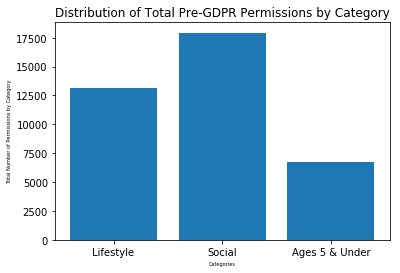

In [19]:
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
plt.bar(np.arange(len(categories)), pre_perm_cat_count)
plt.xlabel('Categories', fontsize=5)
plt.ylabel('Total Number of Permissions by Category', fontsize=5)
plt.xticks(np.arange(len(categories)),categories, fontsize=10)
plt.title('Distribution of Total Pre-GDPR Permissions by Category')
plt.show()

### Histogram of number of post-permissions by category

In [20]:
l_post_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Lifestyle"]['permission_count_post'])
s_post_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Social"]['permission_count_post'])
a_post_permissions = sum(gdpr_merge[gdpr_merge['category_pre'] == "Ages 5 & Under"]['permission_count_post'])
post_perm_cat_count = [l_post_permissions, s_post_permissions, a_post_permissions]
print(post_perm_cat_count)

[14198, 19127, 7104]


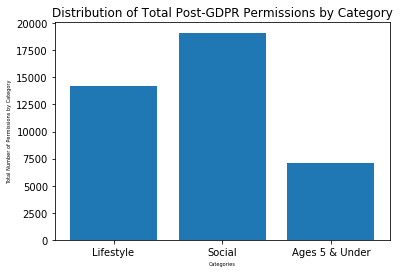

In [21]:
categories = ["Lifestyle", "Social", "Ages 5 & Under"]
plt.bar(np.arange(len(categories)), post_perm_cat_count)
plt.xlabel('Categories', fontsize=5)
plt.ylabel('Total Number of Permissions by Category', fontsize=5)
plt.xticks(np.arange(len(categories)),categories, fontsize=10)
plt.title('Distribution of Total Post-GDPR Permissions by Category')
plt.show()

### Histogram of number of pre-permissions by country

In [22]:
US_pre_permissions = sum(gdpr_merge[gdpr_merge['country'] == "United States"]['permission_count_pre'])
SK_pre_permissions = sum(gdpr_merge[gdpr_merge['country'] == "South Korea"]['permission_count_pre'])
GER_pre_permissions = sum(gdpr_merge[gdpr_merge['country'] == "Germany"]['permission_count_pre'])
pre_perm_country_count = [US_pre_permissions, SK_pre_permissions, GER_pre_permissions]
print(pre_perm_country_count)

[12491, 14403, 10956]


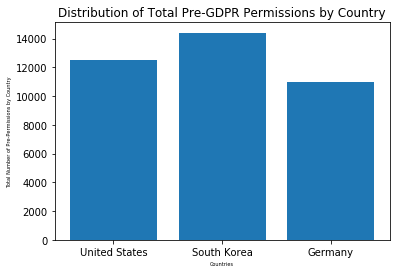

In [23]:
countries = ["United States", "South Korea", "Germany"]
plt.bar(np.arange(len(countries)), pre_perm_country_count)
plt.xlabel('Countries', fontsize=5)
plt.ylabel('Total Number of Pre-Permissions by Country', fontsize=5)
plt.xticks(np.arange(len(countries)),countries, fontsize=10)
plt.title('Distribution of Total Pre-GDPR Permissions by Country')
plt.show()

### Histogram of number of post-permissions by country

In [24]:
US_post_permissions = sum(gdpr_merge[gdpr_merge['country'] == "United States"]['permission_count_post'])
SK_post_permissions = sum(gdpr_merge[gdpr_merge['country'] == "South Korea"]['permission_count_post'])
GER_post_permissions = sum(gdpr_merge[gdpr_merge['country'] == "Germany"]['permission_count_post'])
post_perm_country_count = [US_post_permissions, SK_post_permissions, GER_post_permissions]
print(post_perm_country_count)

[13349, 15185, 11895]


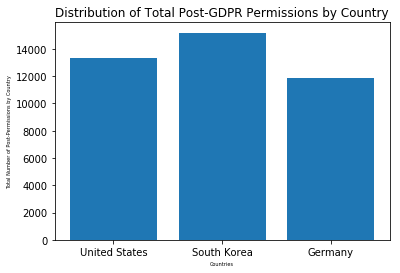

In [25]:
countries = ["United States", "South Korea", "Germany"]
plt.bar(np.arange(len(countries)), post_perm_country_count)
plt.xlabel('Countries', fontsize=5)
plt.ylabel('Total Number of Post-Permissions by Country', fontsize=5)
plt.xticks(np.arange(len(countries)),countries, fontsize=10)
plt.title('Distribution of Total Post-GDPR Permissions by Country')
plt.show()

# Machine Learning Models
## Predicting App Category Post-GDPR
The goal of our first set of models is to predict the app’s category.

In [26]:
#split the train and test data
y = gdpr_merge['category_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge, y, test_size=0.4)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))


length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]

print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1682, 21)
Train_labels: (1682,)
Dev data: (561, 21)
Dev_labels: (561,)
Test_data: (561, 21)
Test_labels: (561,)


In [27]:
gdpr_merge.columns

Index(['package_name', 'country', 'category_pre', 'google_rank_pre',
       'permissions_pre', 'permission_count_pre', 'file_size_pre',
       'category_post', 'google_rank_post', 'permissions_post',
       'permission_count_post', 'file_size_post', 'US', 'South Korea',
       'Germany', 'Lifestyle_pre', 'Ages 5 and Under_pre', 'Social_pre',
       'Lifestyle_post', 'Ages 5 and Under_post', 'Social_post'],
      dtype='object')

In [28]:
train_data = train_data[['US', 'South Korea', 'Germany', 'google_rank_pre','permission_count_pre', 'file_size_pre', 
           'google_rank_post', 'permission_count_post', 'file_size_post']]
dev_data = dev_data[['US', 'South Korea', 'Germany', 'google_rank_pre','permission_count_pre', 'file_size_pre', 
           'google_rank_post', 'permission_count_post', 'file_size_post']]

### Logistic Regression Model

In [29]:
Logistic_model = LogisticRegression(C= .01, penalty = 'l1')
Logistic_model.fit(train_data, train_labels)
Logistic_labels = Logistic_model.predict(dev_data)
   
print('The accuracy for the logistic regression model is : ', metrics.f1_score(dev_labels, Logistic_labels, average= 'weighted'))

The accuracy for the logistic regression model is :  0.5556108113809057


In [30]:
c_list = [0.01, 0.05, 0.1, 0.5, 1]
f1_scores = []
for c in c_list:
    Logistic_model = LogisticRegression(C=c, penalty = 'l1')
    Logistic_model.fit(train_data, train_labels)
    Logistic_labels = Logistic_model.predict(dev_data)
    
    f1_scores.append(metrics.f1_score(dev_labels, Logistic_labels, average = 'weighted'))
index = f1_scores.index(max(f1_scores))
max_f1 = max(f1_scores)
print ("The optimal value for c is " + str(c_list[index]) + " with a f1_score of " + str(max_f1))


The optimal value for c is 0.1 with a f1_score of 0.610037778237687


### Nearest Neighbors

In [31]:
k_list = [1,3,5,7,9,11,13]    
f1_scores = []
for k in k_list:
    KNN_model = KNeighborsClassifier(n_neighbors = k) 
    KNN_model.fit(train_data,train_labels)
    KNN_labels = KNN_model.predict(dev_data) 
    f1_scores.append(metrics.f1_score(dev_labels,KNN_labels, average = 'weighted'))
index = f1_scores.index(max(f1_scores))
max_f1 = max(f1_scores)
print ("The optimal value for k is " + str(k_list[index]) + " with a f1_score of " + str(max_f1))

    


The optimal value for k is 1 with a f1_score of 0.6393197297139419


### MultiNomial Naive Bayes

In [32]:
a_list = [0.01,0.05,0.1,0.5,1,2]    
f1_scores = []
for a in a_list:
    MNNB_model = MultinomialNB(alpha = a) 
    MNNB_model.fit(train_data,train_labels)
    MNNB_labels = MNNB_model.predict(dev_data)
    f1_scores.append(metrics.f1_score(dev_labels, MNNB_labels, average = 'weighted'))
index = f1_scores.index(max(f1_scores))
max_f1 = max(f1_scores)
print ("The optimal value for a is " + str(a_list[index]) + " with a f1_score of " + str(max_f1))



The optimal value for a is 0.01 with a f1_score of 0.35446708353943257


##  Random Forest

In [33]:
rf_model = RandomForestClassifier(n_estimators =100, max_depth = None, random_state = 0, criterion = 'entropy')
rf_model.fit(train_data,train_labels)
rf_labels = rf_model.predict(dev_data)
print('Random Forest: ', metrics.f1_score(dev_labels, rf_labels, average = 'weighted'))


Random Forest:  0.6472986893770493


## Predicting Post-GDPR Google Rank
The goal of our second set of models is to predict the app’s post-GDPR google rank.

In [34]:
#split the train and test data
y = gdpr_merge['google_rank_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge, y, test_size=0.4)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))


length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]

print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1682, 21)
Train_labels: (1682,)
Dev data: (561, 21)
Dev_labels: (561,)
Test_data: (561, 21)
Test_labels: (561,)


List all the columns

In [35]:
gdpr_merge.columns

Index(['package_name', 'country', 'category_pre', 'google_rank_pre',
       'permissions_pre', 'permission_count_pre', 'file_size_pre',
       'category_post', 'google_rank_post', 'permissions_post',
       'permission_count_post', 'file_size_post', 'US', 'South Korea',
       'Germany', 'Lifestyle_pre', 'Ages 5 and Under_pre', 'Social_pre',
       'Lifestyle_post', 'Ages 5 and Under_post', 'Social_post'],
      dtype='object')

Pick only the columns that we want

In [36]:
train_data = train_data[['US', 'South Korea', 'Germany','google_rank_pre','permission_count_pre', 'file_size_pre',
                         'permission_count_post', 'file_size_post']]
dev_data = dev_data[['US', 'South Korea', 'Germany', 'google_rank_pre','permission_count_pre', 'file_size_pre', 
            'permission_count_post', 'file_size_post']]

### Linear Regression

In [37]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2_model= lin_model.score(train_data, train_labels)  
print ("The R^2 of the regression model is " + str(r2_model))

The R^2 of the regression model is 0.5059195460349204


SHould we print out the coefficients of the regression?

### Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators =100, max_depth = None, random_state = 0, criterion = 'entropy')
rf_model.fit(train_data,train_labels)
rf_labels = rf_model.predict(dev_data)
print('Random Forest: ', metrics.f1_score(dev_labels, rf_labels, average = 'weighted'))

Random Forest:  0.00267379679144385


In [39]:
rf_model = RandomForestClassifier(n_estimators =100, max_depth = 2, random_state = 0)
rf_model.fit(train_data,train_labels)
rf_labels = rf_model.predict(dev_data)
print('Random Forest: ', metrics.f1_score(dev_labels, rf_labels, average = 'weighted'))

Random Forest:  0.0001755013560078639


Why are the f1 scores for the random forest so low?
How can we compare the R^2 reading to the f1 score?

## Predicting the Number of Permissions Requests Post-GDPR
The goal of our third set of models is to predict the number of permissions requests after GDPR.

In [40]:
#split the train and test data
y = gdpr_merge['permission_count_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge, y, test_size=0.4)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))


length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]

print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1682, 21)
Train_labels: (1682,)
Dev data: (561, 21)
Dev_labels: (561,)
Test_data: (561, 21)
Test_labels: (561,)


List all the columns

In [41]:
gdpr_merge.columns

Index(['package_name', 'country', 'category_pre', 'google_rank_pre',
       'permissions_pre', 'permission_count_pre', 'file_size_pre',
       'category_post', 'google_rank_post', 'permissions_post',
       'permission_count_post', 'file_size_post', 'US', 'South Korea',
       'Germany', 'Lifestyle_pre', 'Ages 5 and Under_pre', 'Social_pre',
       'Lifestyle_post', 'Ages 5 and Under_post', 'Social_post'],
      dtype='object')

Pick only the columns that we want

In [42]:
train_data = train_data[['US', 'South Korea', 'Germany','google_rank_pre','permission_count_pre', 'file_size_pre',
                         'permission_count_post', 'file_size_post']]
dev_data = dev_data[['US', 'South Korea', 'Germany', 'google_rank_pre','permission_count_pre', 'file_size_pre', 
            'permission_count_post', 'file_size_post']]

### Linear Regression

In [43]:
lin_model = LinearRegression()
lin_model.fit(train_data, train_labels)
predicted_accuracy = lin_model.predict(dev_data)
r2_model= lin_model.score(train_data, train_labels)  
print ("The R^2 of the regression model is " + str(r2_model))

The R^2 of the regression model is 1.0


Why do we get a R^2 of 1.0 here?

### Random Forest

In [44]:
rf_model = RandomForestClassifier(n_estimators =100, max_depth = None, random_state = 0, criterion = 'entropy')
rf_model.fit(train_data,train_labels)
rf_labels = rf_model.predict(dev_data)
print('Random Forest: ', metrics.f1_score(dev_labels, rf_labels, average = 'weighted'))


Random Forest:  0.8861447136294764


In [45]:
rf_model = RandomForestClassifier(n_estimators =100, max_depth = 2, random_state = 0)
rf_model.fit(train_data,train_labels)
rf_labels = rf_model.predict(dev_data)
print('Random Forest: ', metrics.f1_score(dev_labels, rf_labels, average = 'weighted'))


Random Forest:  0.2466373601338762


## Dealing with Unique Permisions ??

In [46]:
#split the train and test data
y = gdpr_merge['permission_count_post']
train_data, X, train_labels, Y = train_test_split(gdpr_merge, y, test_size=0.4)
print ("Train_data: " + str(train_data.shape))
print ("Train_labels: " + str(train_labels.shape))


length = int(len(X)/2)
dev_data = X[0:length]
dev_labels = Y[0:length]
test_data = X[length:]
test_labels = Y[length:]

print ("Dev data: " + str(dev_data.shape))
print ("Dev_labels: " + str(dev_labels.shape))
print ("Test_data: " + str(test_data.shape))
print ("Test_labels: " + str(test_labels.shape))

Train_data: (1682, 21)
Train_labels: (1682,)
Dev data: (561, 21)
Dev_labels: (561,)
Test_data: (561, 21)
Test_labels: (561,)


List all the columns

In [47]:
gdpr_merge.columns

Index(['package_name', 'country', 'category_pre', 'google_rank_pre',
       'permissions_pre', 'permission_count_pre', 'file_size_pre',
       'category_post', 'google_rank_post', 'permissions_post',
       'permission_count_post', 'file_size_post', 'US', 'South Korea',
       'Germany', 'Lifestyle_pre', 'Ages 5 and Under_pre', 'Social_pre',
       'Lifestyle_post', 'Ages 5 and Under_post', 'Social_post'],
      dtype='object')

Pick only the columns that we want

In [48]:
train_data = train_data[['US', 'South Korea', 'Germany','google_rank_pre','permission_count_pre', 'file_size_pre',
                         'permission_count_post', 'file_size_post', 'permissions_pre', 'permissions_post']]
dev_data = dev_data[['US', 'South Korea', 'Germany', 'google_rank_pre','permission_count_pre', 'file_size_pre', 
            'permission_count_post', 'file_size_post', 'permissions_pre', 'permissions_post']]

In [49]:
#we want a list/set containing all of the unique permissions in the dataset
# new_permissions_list = []
unique_permissions = []
# we can start by creating a list of each row's permissions:all_permissions (which will be lists too)
permissions = [i for i in gdpr_merge['permissions_pre']]

for i in permissions:
    new_permissions = i.strip('][').split(', ')
# print (new_permissions)
#     new_permissions_list.append(new_permissions) #new_permissions_list is the combo for each row
# new_permissions_list
    for x in new_permissions:
        # check if exists in unique_permissions list or not
        if x not in unique_permissions:
            unique_permissions.append(x)
unique_permissions
# print('There are', len(unique_permissions), 'unique permissions in the dataset.','\n')
# for i in unique_permissions:
#     print(i)

["'android.permission.INTERNET'",
 "'android.permission.ACCESS_NETWORK_STATE'",
 "'android.permission.ACCESS_COARSE_LOCATION'",
 "'android.permission.ACCESS_FINE_LOCATION'",
 "'android.permission.WRITE_EXTERNAL_STORAGE'",
 "'android.permission.READ_PHONE_STATE'",
 "'android.permission.READ_EXTERNAL_STORAGE'",
 "'android.permission.WAKE_LOCK'",
 "'com.google.android.c2dm.permission.RECEIVE'",
 "'app.fortunebox.permission.C2D_MESSAGE'",
 "'android.permission.VIBRATE'",
 "'android.permission.RECEIVE_BOOT_COMPLETED'",
 "'com.sec.android.provider.badge.permission.READ'",
 "'com.sec.android.provider.badge.permission.WRITE'",
 "'com.htc.launcher.permission.READ_SETTINGS'",
 "'com.htc.launcher.permission.UPDATE_SHORTCUT'",
 "'com.sonyericsson.home.permission.BROADCAST_BADGE'",
 "'com.sonymobile.home.permission.PROVIDER_INSERT_BADGE'",
 "'com.anddoes.launcher.permission.UPDATE_COUNT'",
 "'com.majeur.launcher.permission.UPDATE_BADGE'",
 "'com.huawei.android.launcher.permission.CHANGE_BADGE'",
 "

In [50]:
#we want a list/set containing all of the unique permissions in the dataset
unique_permissions = []


# we can start by creating a list of each row's permissionsall_permissions (which will be a list of lists
permissions = [i for i in gdpr_merge['permissions_pre']]
print(permissions[0])

for i in permissions:
    new_permissions = i.strip('][').split(', ')

    for x in new_permissions:
        # check if exists in unique_permissions list or not
        if x not in unique_permissions:
            unique_permissions.append(x)

print('There are', len(unique_permissions), 'unique permissions in the dataset.','\n')
for i in unique_permissions:
    print(i.strip('\''))

['android.permission.INTERNET', 'android.permission.ACCESS_NETWORK_STATE']
There are 2281 unique permissions in the dataset. 

android.permission.INTERNET
android.permission.ACCESS_NETWORK_STATE
android.permission.ACCESS_COARSE_LOCATION
android.permission.ACCESS_FINE_LOCATION
android.permission.WRITE_EXTERNAL_STORAGE
android.permission.READ_PHONE_STATE
android.permission.READ_EXTERNAL_STORAGE
android.permission.WAKE_LOCK
com.google.android.c2dm.permission.RECEIVE
app.fortunebox.permission.C2D_MESSAGE
android.permission.VIBRATE
android.permission.RECEIVE_BOOT_COMPLETED
com.sec.android.provider.badge.permission.READ
com.sec.android.provider.badge.permission.WRITE
com.htc.launcher.permission.READ_SETTINGS
com.htc.launcher.permission.UPDATE_SHORTCUT
com.sonyericsson.home.permission.BROADCAST_BADGE
com.sonymobile.home.permission.PROVIDER_INSERT_BADGE
com.anddoes.launcher.permission.UPDATE_COUNT
com.majeur.launcher.permission.UPDATE_BADGE
com.huawei.android.launcher.permission.CHANGE_BADGE
c

com.esstudio.clien.permission.C2D_MESSAGE
com.estickerapp.android.permission.C2D_MESSAGE
com.exien.boardall.permission.C2D_MESSAGE
com.facebook.lite.permission.C2D_MESSAGE
com.facebook.receiver.permission.ACCESS
com.facebook.orca.provider.ACCESS
com.facebook.mlite.provider.ACCESS
com.facebook.wakizashi.provider.ACCESS
com.facebook.permission.prod.FB_APP_COMMUNICATION
com.fastlane.snackar.permission.C2D_MESSAGE
com.fingerrap.mcdown2016.permission.C2D_MESSAGE
com.fingerrap.minemapstwo20161023.permission.C2D_MESSAGE
com.friendscube.somoim.permission.C2D_MESSAGE
com.fuzixx.dokidokipostbox.permission.C2D_MESSAGE
android.intent.action.MEDIA_MOUNTED
com.gayeon.service.once.permission.C2D_MESSAGE
android.permission.NETWORK
com.ghsoft.android.talk_friend.permission.C2D_MESSAGE
com.goodoc.community.permission.C2D_MESSAGE
com.gun0912.kakao.permission.C2D_MESSAGE
com.gwh.falling.permission.C2D_MESSAGE
com.hellopal.android.permission.JPUSH_MESSAGE
com.hellopal.android.permission.C2D_MESSAGE
com.hel

In [78]:
all_permissions_pre = gdpr_merge['permissions_pre']
lst = []
for i in all_permissions_pre:
    a = i.split("\"")
    for j in a:
        lst.append(j)
gdpr_merge["pre_parsed"] = lst

all_permissions_post = gdpr_merge['permissions_post']
lst2 = []
for i in all_permissions_post:
    a = i.split("\"")
    for j in a:
        lst2.append(j)
gdpr_merge["post_parsed"] = lst2
gdpr_merge

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,South Korea,Germany,Lifestyle_pre,Ages 5 and Under_pre,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,0,1,0,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,1,0,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '..."
5,appinventor.ai_payas1965.PAIRSSpiritBox,United States,Lifestyle,256,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,12996212,Lifestyle,216,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,0,1,0,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '..."
6,catch.a.cheatinglover,United States,Lifestyle,378,"['android.permission.INTERNET', 'android.permi...",9,6792037,Lifestyle,251,"['android.permission.INTERNET', 'android.permi...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi..."
7,ch.bitspin.timely,United States,Lifestyle,314,"['.permission.C2D_MESSAGE', 'com.google.androi...",15,9836258,Lifestyle,518,"['.permission.C2D_MESSAGE', 'com.google.androi...",...,0,0,1,0,0,1,0,0,"['.permission.C2D_MESSAGE', 'com.google.androi...","['.permission.C2D_MESSAGE', 'com.google.androi..."
8,cjvg.santabiblia,United States,Lifestyle,153,"['android.permission.RECEIVE_BOOT_COMPLETED', ...",7,6489374,Lifestyle,192,"['android.permission.RECEIVE_BOOT_COMPLETED', ...",...,0,0,1,0,0,1,0,0,"['android.permission.RECEIVE_BOOT_COMPLETED', ...","['android.permission.RECEIVE_BOOT_COMPLETED', ..."
9,co.snaptee.android,United States,Lifestyle,218,"['android.permission.INTERNET', 'android.permi...",11,46430921,Lifestyle,294,"['android.permission.ACCESS_WIFI_STATE', 'andr...",...,0,0,1,0,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.ACCESS_WIFI_STATE', 'andr..."


In [52]:
  
    # intilize a null list 
unique_list = [] 
      
    # traverse for all elements 
for x in lst: 
    # check if exists in unique_list or not 
    if x not in unique_list: 
        unique_list.append(x) 
print (unique_list)

['[', 'android.permission.INTERNET', ', ', 'android.permission.ACCESS_NETWORK_STATE', ']', 'android.permission.ACCESS_COARSE_LOCATION', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.READ_PHONE_STATE', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.WAKE_LOCK', 'com.google.android.c2dm.permission.RECEIVE', 'app.fortunebox.permission.C2D_MESSAGE', 'android.permission.VIBRATE', 'android.permission.RECEIVE_BOOT_COMPLETED', 'com.sec.android.provider.badge.permission.READ', 'com.sec.android.provider.badge.permission.WRITE', 'com.htc.launcher.permission.READ_SETTINGS', 'com.htc.launcher.permission.UPDATE_SHORTCUT', 'com.sonyericsson.home.permission.BROADCAST_BADGE', 'com.sonymobile.home.permission.PROVIDER_INSERT_BADGE', 'com.anddoes.launcher.permission.UPDATE_COUNT', 'com.majeur.launcher.permission.UPDATE_BADGE', 'com.huawei.android.launcher.permission.CHANGE_BADGE', 'com.huawei.android.launcher.permission.READ_SET

In [89]:
all_permissions[3]

"['android.permission.GET_ACCOUNTS', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_NETWORK_STATE', 'android.permission.BLUETOOTH', 'android.permission.INTERNET', 'android.permission.RECEIVE_BOOT_COMPLETED', 'android.permission.WAKE_LOCK', 'android.permission.SYSTEM_ALERT_WINDOW', 'app.ven.c2dm.permission.RECEIVE', 'android.permission.READ_EXTERNAL_STORAGE', 'com.android.vending.BILLING', 'android.permission.VIBRATE', 'android.permission.RECORD_AUDIO', 'android.permission.READ_PHONE_STATE', 'android.permission.ACCESS_WIFI_STATE', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'app.ven.permission.C2D_MESSAGE', 'com.google.android.c2dm.permission.RECEIVE', 'android.permission.WRITE_EXTERNAL_STORAGE', 'android.permission.ACCESS_FINE_LOCATION']"

In [116]:
import re
dangerous = ["READ_CALENDAR", "WRITE_CALENDAR", "READ_CALL_LOG", 
             "WRITE_CALL_LOG", "PROCESS_OUTGOING_CALLS", "CAMERA",
             "READ_CONTACTS", "WRITE_CONTACTS", "GET_ACCOUNTS", 
             "ACCESS_FINE_LOCATION", "ACCESS_COURSE_LOCATION", 
             "RECORD_AUDIO", "READ_PHONE_STATE", "READ_PHONE_NUMBERS", 
             "CALL_PHONE", "ANSWER_PHONE_CALLS", "ADD_VOICEMAIL", 
             "USE_SIP", "BODY_SENSORS", "SEND_SMS", "RECEIVE_SMS", 
             "READ_SMS", "RECEIVE_WAP_PUSH", "RECEIVE_MMS", 
             "READ_EXTERNAL_STORAGE","WRITE_EXTERNAL_STORAGE"]
dang = []
safe = []
for row in gdpr_merge["pre_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang.append(dangs)
    safe.append(safes)

gdpr_merge["pre_parsed_dangerous"] = dang
gdpr_merge["pre_parsed_safe"] = safe

dang2 = []
safe2 = []
for row in gdpr_merge["post_parsed"]:
    perms = re.findall("[A-Z]\w+", row)
    dangs = []
    safes = []   
    for perm in perms: 
        if perm in dangerous:
            dangs.append(1)
            safes.append(0)
        else:
            dangs.append(0)
            safes.append(1)
    dang2.append(dangs)
    safe2.append(safes)
gdpr_merge["post_parsed_dangerous"] = dang2
gdpr_merge["post_parsed_safe"] = safe2

gdpr_merge

,package_name,country,category_pre,google_rank_pre,permissions_pre,permission_count_pre,file_size_pre,category_post,google_rank_post,permissions_post,...,Social_pre,Lifestyle_post,Ages 5 and Under_post,Social_post,pre_parsed,post_parsed,pre_parsed_dangerous,pre_parsed_safe,post_parsed_dangerous,post_parsed_safe
0,aegean.secretnotepad,United States,Lifestyle,325,"['android.permission.INTERNET', 'android.permi...",2,3369399,Lifestyle,232,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0]","[1, 1]","[0, 0]","[1, 1]"
1,app.fortunebox,United States,Lifestyle,50,"['android.permission.INTERNET', 'android.permi...",28,4729070,Lifestyle,380,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,app.quiktrip.com.quiktrip,United States,Lifestyle,74,"['android.permission.INTERNET', 'android.permi...",21,17948194,Lifestyle,96,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ..."
3,app.ven,United States,Lifestyle,417,"['android.permission.GET_ACCOUNTS', 'android.p...",20,12289507,Lifestyle,471,"['android.permission.GET_ACCOUNTS', 'android.p...",...,0,1,0,0,"['android.permission.GET_ACCOUNTS', 'android.p...","['android.permission.GET_ACCOUNTS', 'android.p...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, ..."
4,appinventor.ai_created4each.My_Diary,United States,Lifestyle,280,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,4486289,Lifestyle,529,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]"
5,appinventor.ai_payas1965.PAIRSSpiritBox,United States,Lifestyle,256,"['android.permission.READ_EXTERNAL_STORAGE', '...",6,12996212,Lifestyle,216,"['android.permission.READ_EXTERNAL_STORAGE', '...",...,0,1,0,0,"['android.permission.READ_EXTERNAL_STORAGE', '...","['android.permission.READ_EXTERNAL_STORAGE', '...","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]","[1, 1, 0, 0, 0, 0]","[0, 0, 1, 1, 1, 1]"
6,catch.a.cheatinglover,United States,Lifestyle,378,"['android.permission.INTERNET', 'android.permi...",9,6792037,Lifestyle,251,"['android.permission.INTERNET', 'android.permi...",...,0,1,0,0,"['android.permission.INTERNET', 'android.permi...","['android.permission.INTERNET', 'android.permi...","[0, 0, 0, 0, 1, 1, 1, 0, 0]","[1, 1, 1, 1, 0, 0, 0, 1, 1]","[0, 1, 0, 0, 0, 0, 0]","[1, 0, 1, 1, 1, 1, 1]"
7,ch.bitspin.timely,United States,Lifestyle,314,"['.permission.C2D_MESSAGE', 'com.google.androi...",15,9836258,Lifestyle,518,"['.permission.C2D_MESSAGE', 'com.google.androi...",...,0,1,0,0,"['.permission.C2D_MESSAGE', 'com.google.androi...","['.permission.C2D_MESSAGE', 'com.google.androi...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]"
8,cjvg.santabiblia,United States,Lifestyle,153,"['android.permission.RECEIVE_BOOT_COMPLETED', ...",7,6489374,Lifestyle,192,"['android.permission.RECEIVE_BOOT_COMPLETED', ...",.